<a href="https://colab.research.google.com/github/azavalac/SFH_dwarf_galaxies/blob/main/ProyectoModulo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
#instalamos artpop
!pip install artpop

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u

import artpop

# artpop's matplotlib style
plt.style.use(artpop.mpl_style)

# use this random state for reproducibility
rng = np.random.RandomState(112)

BLOQUE CON LA FUNCION QUE DEVUELVE UN CSP A PARTIR DE 2 LISTAS CON EDADES Y SFR

In [81]:
#BLOQUE CON LA FUNCION QUE DEVUELVE UN CSP A PARTIR DE 2 LISTAS CON EDADES Y SFR

#sfh_to_ssp: list x list -> csp
#
#
def shf_to_csp(r, t):
  array_ssp = []

  for i in range(r.shape):
    edad = t
    sfr = r
    #print(edad)
    #print("edad en log age: ", np.log10(edad))
    #print("sfr: ", sfr)

    ssp = artpop.MISTSSP(
      log_age = np.log10(edad), # log of age in years
      num_stars = sfr,      # number of stars
      feh = -1,             # metallicity [Fe/H]
      phot_system = 'LSST', # photometric system(s)
      random_state = rng,   # random state for reproducibility
    )

    array_ssp.append(ssp)

  csp = array_ssp[0]

  for i in range(1, len(array_ssp)):
    csp = csp + array_ssp[i]

  return csp


Función que crea las SFH

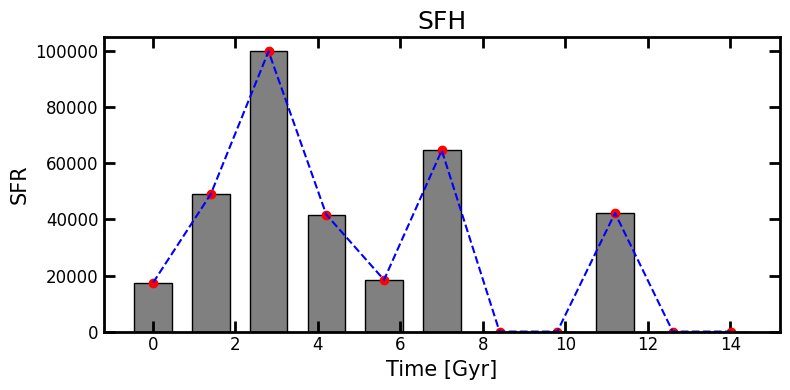

In [82]:
def create_sfh(n_points, n_stars, H_noise=30):
    #n_stars es el numero final de estrellas q podriamos formar
    # Randomize amplitude and phase
    rho = np.random.rand(H_noise) * np.logspace(0.5, -2.5, H_noise)
    phi = np.random.rand(H_noise) * 2 * np.pi

    # Accumulate r(t) over t = [0, 2*pi]
    t = np.linspace(0, np.pi, n_points+1)
    r = np.ones_like(t)
    for h in range(1, H_noise + 1):
        r += rho[h - 1] * np.sin(h * t + phi[h - 1])

    # Update t to go from 0 to 14.
    t = 1e-3+t*14 / np.pi

    # Update r to go from 0 to 1
    r_mask = r < 0.6 # Esto es para tener regiones sin formación. Este parámetro se puede variar

    r = r/r.max()
    r[r_mask] = 0
    r *= n_stars / n_points

    return r, t



def display_sfh(r, t):
    plt.figure(figsize=(8, 4))
    plt.title('SFH', fontsize=18)

    plt.bar(t, r, color='grey', width=10/len(t), edgecolor='black')
    plt.plot(t, r, 'ro')
    plt.plot(t, r, '--b')
    plt.xlabel('Time [Gyr]', fontsize=15)
    plt.ylabel('SFR', fontsize=15)

    plt.tick_params(axis='both', labelsize=12)
    plt.tight_layout()
    plt.show()

ra, ta = create_sfh(10,1e6, 100)
display_sfh(ra, ta)

Algunas pruebas de la función create_sfh

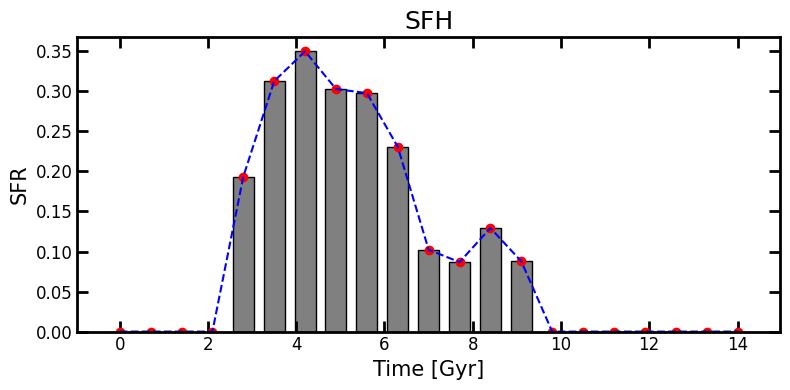

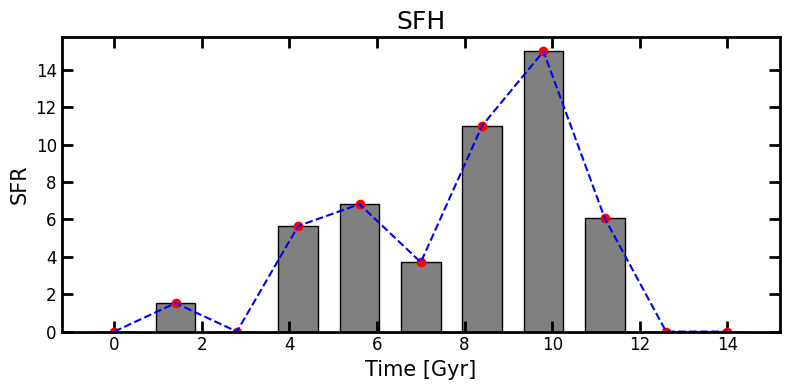

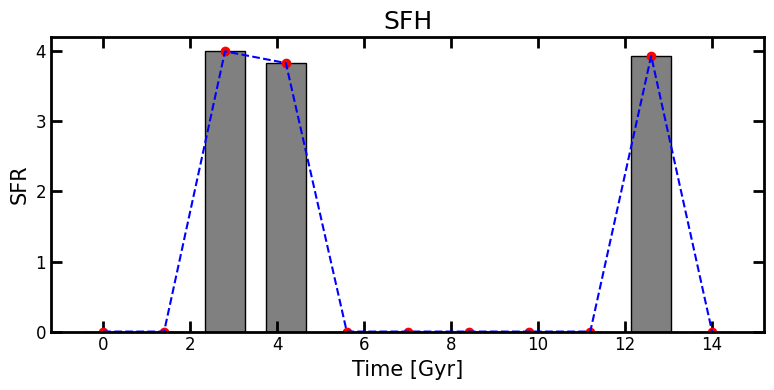

In [83]:
r1, t1 = create_sfh(20, 7) # Probamos con un r=20 para tener mas puntos y t=7 el cual da pertubaciones mas suaves
display_sfh(r1, t1)

r2, t2 = create_sfh(10, 150) # Probamos t=150 el cual da pertubaciones mas grandes
display_sfh(r2, t2)

r3, t3 = create_sfh(10, 40) # Probamos t=1 el cual da pertubaciones mas pequeñas
display_sfh(r3, t3)

Función que crea CSP a partir de un SFH

In [84]:
#sfh_to_ssp: list x list -> csp
#
#
def sfh_to_csp(sfh_r, sfh_t):

  array_ssp = []
  sfh_logage = np.log10(sfh_t*1e9)

  for i, (r,t) in enumerate(zip(sfh_r, sfh_logage)):
    if r == 0:
            continue
    #print(edad)
    #print("edad en log age: ", np.log10(edad))
    #print("sfr: ", sfr)

    ssp_i = artpop.MISTSSP(
      log_age = t, # log of age in years
      num_stars = r,      # number of stars
      feh = -1,             # metallicity [Fe/H]
      phot_system = 'LSST', # photometric system(s)
      random_state = rng,   # random state for reproducibility
    )
    array_ssp.append(ssp_i)

  csp = array_ssp[0]
  for i in range(1, len(array_ssp)):
    ssp_i = array_ssp[i]
    if ssp_i.num_stars > 0:
        csp = csp + ssp_i
  return csp



print(sfh_to_csp(ra, ta))
print("---------||--------")
print(sfh_to_csp(r1, t1))

Composite Population
--------------------
N_pops = 7
M_star = 1.47e+05 M_sun
number fractions = ['5.22%', '14.70%', '29.97%', '12.51%', '5.53%', '19.38%', '12.68%']
mass fractions = ['7.79%', '14.57%', '29.12%', '12.22%', '5.34%', '18.71%', '12.25%']
log(age/yr) = [6.0, 9.146438135285775, 9.447313108823568, 9.623352681537993, 9.74826557266874, 9.845160077651945, 10.049256797232227]
[Fe/H] = [-1, -1, -1, -1, -1, -1, -1]
photometric system = LSST
---------||--------
Simple Stellar Population
-------------------------
M_star = 0.00e+00 M_sun
log(age/yr) = 9.447313108823568
[Fe/H] = -1
photometric system = LSST


Función que crea CSP de una (sin necesidad de hacer la sfh antes)

In [85]:
def create_csp(n_points, n_stars=1e6, H_noise=30): #esta función crea csp's de una
    r, t = create_sfh(n_points, n_stars, H_noise=30)
    csp_ = sfh_to_csp(r, t)
    return csp_, r, t

csp_, r, t = create_csp(10)
csp_1, r1, t1 = create_csp(20)

In [86]:
def compute_magerr(m, b):
    dm = 10**(9.5)*2.5/np.log(10) * np.sqrt(1/(10**(b-m/2.5)))
    return np.random.normal(m, dm)

Función que crea los CMD's a partir de SFH + errores

(array([1.98090505, 0.70482225, 1.09299925, ..., 2.05957891, 2.21438425,
        1.78506169]),
 array([ 7.33044705,  3.30961403,  4.7534545 , ..., 11.16576784,
         9.11471404,  9.00616082]))

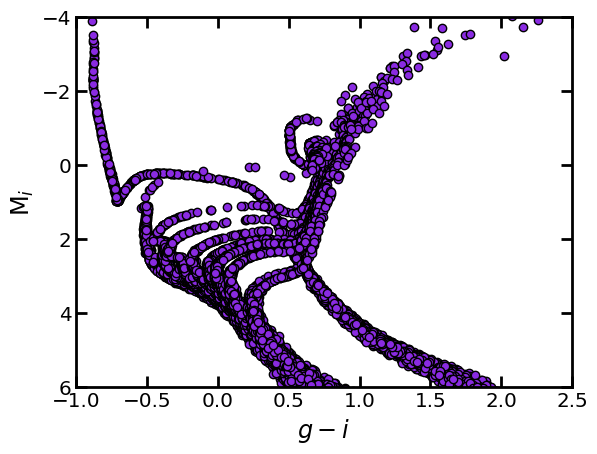

In [87]:
def cmd_from_sfh(r, t , plot=True): #esta función crea cmd's
    csp = sfh_to_csp(r, t)

    '''Construir el CMD'''
    i = csp.star_mags('LSST_i')
    bi = 24.36
    i_err = compute_magerr(i, bi)

    g = csp.star_mags('LSST_g')
    bg = 25.11
    g_err = compute_magerr(g, bg)

    if plot:
        plt.figure()
        plt.plot(g_err-i_err, i_err, 'o', c='blueviolet', mec='k')
        plt.xlim(-1, 2.5)
        plt.ylim(-4, 6)
        plt.gca().invert_yaxis()

        plt.xlabel(r'$g-i$')
        plt.ylabel(r'M$_i$');

    return g_err-i_err, i_err

cmd_from_sfh(r1, t1)

Función que hace el histograma del CMD


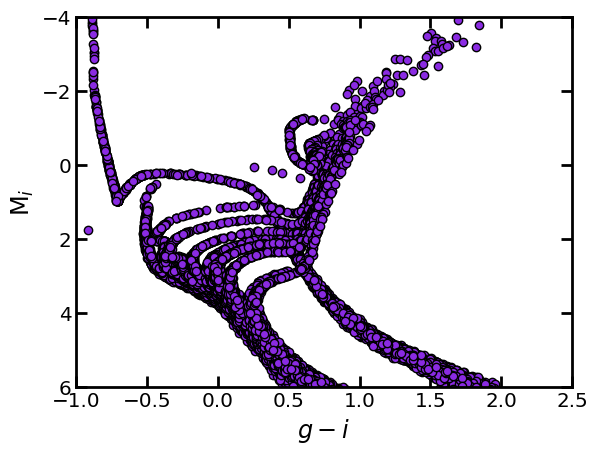

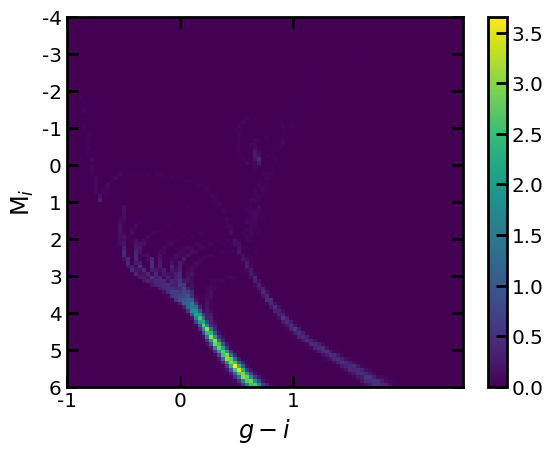

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-4. , -3.9, -3.8, -3.7, -3.6, -3.5, -3.4, -3.3, -3.2, -3.1, -3. ,
        -2.9, -2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2. , -1.9,
        -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8,
        -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,
         0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,
         1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,  2.3,  2.4,  2.5,
         2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,  3.4,  3.5,  3.6,
         3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,  4.5,  4.6,  4.7,
         4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,  5.6,  5.7,  5.8,
         5.9,  6. ]),
 array([-1.   , -0.965, -0.93 , -0.895, -0.86 , -0.825, -0.79 ,

In [88]:
def histogram2d_from_sfh(r, t , bins=100): # Genera y grafica el histograma 2D del CMD a partir de una SFH.

    cmd= cmd_from_sfh(r, t)

    H, yedges, xedges = np.histogram2d(cmd[1], cmd[0], bins=bins, density=True, range=[[-4, 6],[-1, 2.5]])
    plt.figure()
    plt.pcolormesh(xedges, yedges[::-1], H)
    plt.yticks(np.arange(-4, 7, 1), np.arange(6, -5, -1))
    plt.xticks(np.arange(-1, 2, 1), np.arange(-1, 2, 1))
    plt.colorbar()
    plt.xlabel(r'$g-i$')
    plt.ylabel(r'M$_i$')
    plt.show()

    return H, yedges, xedges

histogram2d_from_sfh(r1, t1)

Función que hace la grilla de SFH

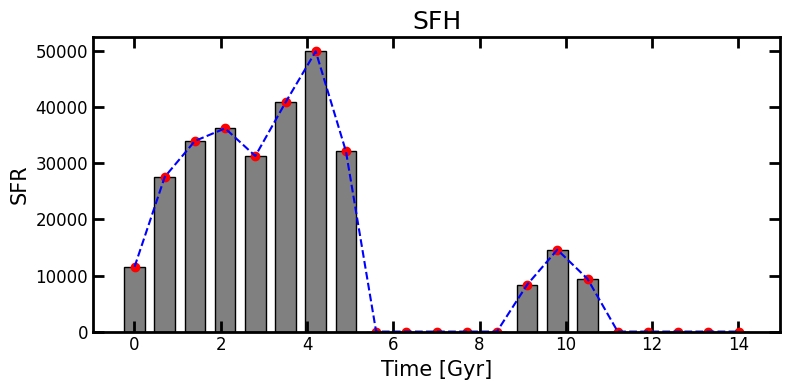

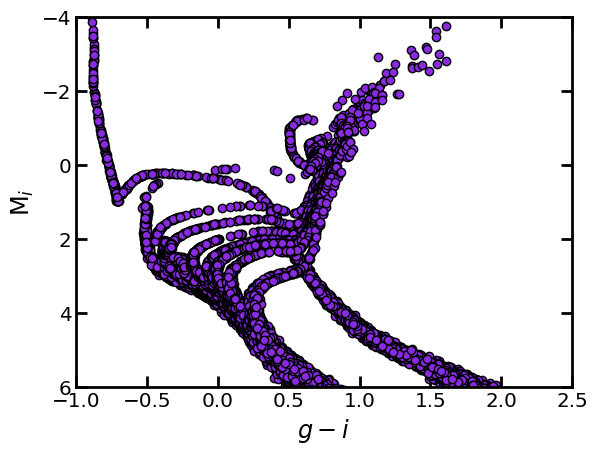

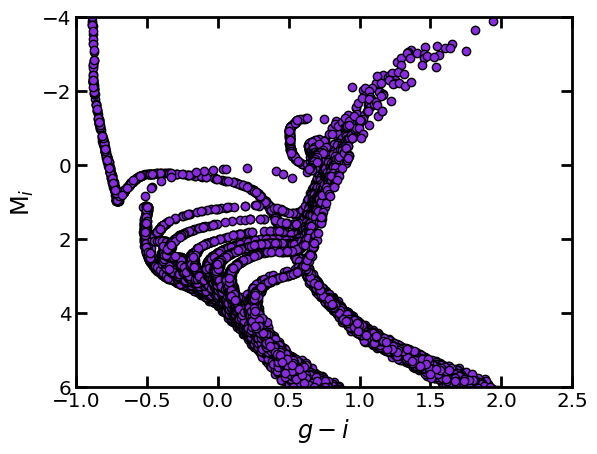

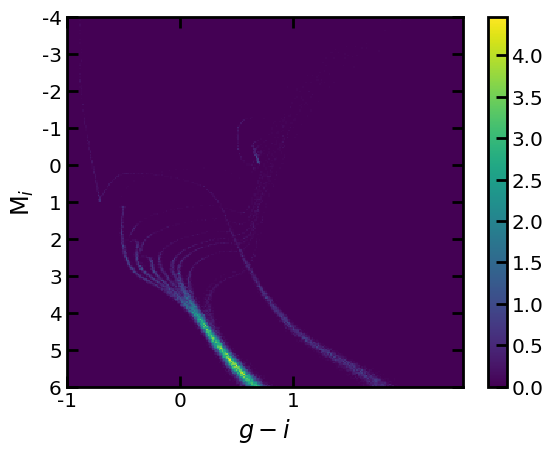

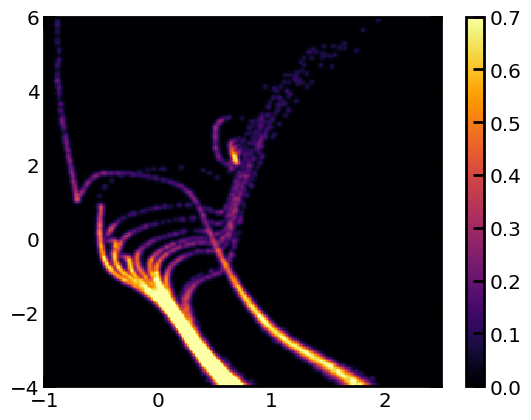

In [89]:
from scipy.ndimage import gaussian_filter

def grilla_sfh(r, t):

    # Generar la población estelar compuesta (CSP) a partir del SFH
    csp = sfh_to_csp(r, t)

    display_sfh(r, t)
    cmd = cmd_from_sfh(r, t);
    H, yed, xed = histogram2d_from_sfh(r, t, bins=256)
    blurred = gaussian_filter(H, sigma=1)

    stamp = np.clip(np.sqrt(np.flipud(blurred)), None, 0.7)
    plt.pcolormesh(xed, yed, stamp, cmap='inferno')
    plt.colorbar()

grilla_sfh(r1, t1)

Red neuronal


In [90]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input

# Definir el modelo de forma explícita con Input
def create_sfh_model(input_shape):
    model = Sequential()
    # Añadir explícitamente una capa de entrada
    model.add(Input(shape=input_shape))
    # Primera capa LSTM
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    # Segunda capa LSTM
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.2))
    # Capa densa final
    model.add(Dense(1, activation='linear'))  # salida continua
    return model

# Configurar la forma de entrada
timesteps = 3  # Número de edades (puntos de tiempo)
features = 1   # SFR como única característica
input_shape = (timesteps, features)

# Crear el modelo
model = create_sfh_model(input_shape)
model.compile(optimizer='adam', loss='mse')